In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
# Specify the input
dataset_folder = 'data'
image_extensions=('.jpg', '.jpeg', '.png')

# Get image paths
image_paths = []
for foldername, __, filenames in os.walk(dataset_folder):
    for filename in filenames:
        if filename.lower().endswith(image_extensions):
            image_paths.append(os.path.join(foldername, filename))

Image Shape: (64, 64)
Class: 0


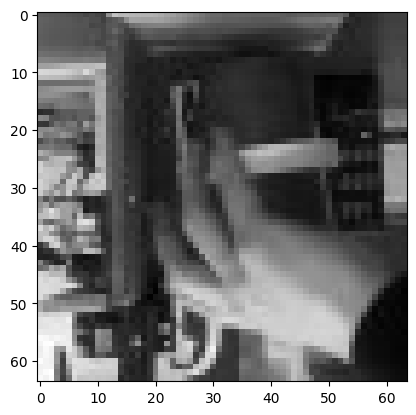

In [13]:
# Load the dataset as grayscale images
X = np.array(list(map(lambda path: cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY), image_paths)))
X = X / 255.0
Y = np.array([1 if 'cup' in path else 0 for path in image_paths])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display one selected image
image_selected = 5
print(f'Image Shape: {X_train[image_selected].shape}')
print(f'Class: {Y_train[image_selected]}')
plt.imshow(X_train[image_selected], cmap='gray')
plt.show()

In [14]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [15]:
# Train the model with less verbosity
history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/17
17/17 - 1s - loss: 0.5802 - accuracy: 0.7077 - val_loss: 0.3770 - val_accuracy: 0.8769 - 1s/epoch - 86ms/step
Epoch 2/17
17/17 - 1s - loss: 0.3015 - accuracy: 0.8865 - val_loss: 0.2359 - val_accuracy: 0.9077 - 866ms/epoch - 51ms/step
Epoch 3/17
17/17 - 1s - loss: 0.1791 - accuracy: 0.9346 - val_loss: 0.1294 - val_accuracy: 0.9462 - 825ms/epoch - 49ms/step
Epoch 4/17
17/17 - 1s - loss: 0.0953 - accuracy: 0.9750 - val_loss: 0.1216 - val_accuracy: 0.9462 - 827ms/epoch - 49ms/step
Epoch 5/17
17/17 - 1s - loss: 0.0827 - accuracy: 0.9750 - val_loss: 0.0633 - val_accuracy: 0.9692 - 829ms/epoch - 49ms/step
Epoch 6/17
17/17 - 1s - loss: 0.0633 - accuracy: 0.9788 - val_loss: 0.0748 - val_accuracy: 0.9615 - 827ms/epoch - 49ms/step
Epoch 7/17
17/17 - 1s - loss: 0.0385 - accuracy: 0.9904 - val_loss: 0.0550 - val_accuracy: 0.9846 - 822ms/epoch - 48ms/step
Epoch 8/17
17/17 - 1s - loss: 0.0240 - accuracy: 0.9981 - val_loss: 0.0390 - val_accuracy: 0.9846 - 828ms/epoch - 49ms/step
Epoch 9/17


In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")

5/5 [==============================] - 0s 7ms/step - loss: 0.0139 - accuracy: 0.9923
Test accuracy: 0.9923076629638672


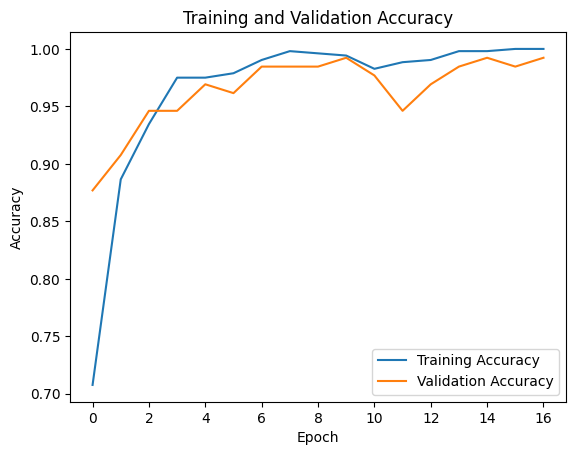

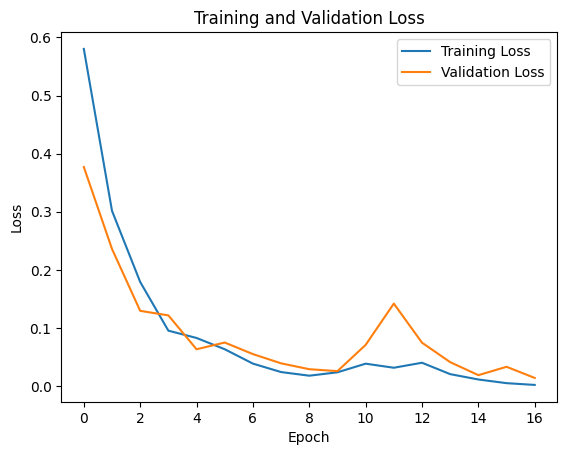

In [16]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict values for the test set
Y_pred = model.predict(X_test)

# Convert the predicted probabilities to binary class labels (0 or 1)
Y_pred_classes = (Y_pred > 0.5).astype(int)
Y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
classification_rep = classification_report(Y_true, Y_pred_classes)
print("Classification Report:")
print(classification_rep)

In [18]:
# Save the trained model
model.save('model.h5', save_format='h5')